<a href="https://colab.research.google.com/github/lonsst/0_git_basics/blob/master/ML_Voice_Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install noisereduce

In [ ]:
import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import noisereduce as nr
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

1. Загрузить датасет Dusha и сделать EDA анализ.

In [ ]:
!wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/dusha/crowd.tar

--2023-12-28 06:02:42--  https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/dusha/crowd.tar
Resolving n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)... 37.230.193.192
Connecting to n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)|37.230.193.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30476994560 (28G) [application/x-tar]
Saving to: ‘crowd.tar’

crowd.tar           100%[===================>]  28.38G  20.8MB/s    in 23m 56s 

2023-12-28 06:26:44 (20.2 MB/s) - ‘crowd.tar’ saved [30476994560/30476994560]



In [ ]:
tar_file_path = 'crowd.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

print(f'Файл {tar_file_path} успешно разархивирован')

Файл crowd.tar успешно разархивирован


In [ ]:
def load_data_train(path, columns_to_drop=['hash_id', 'source_id']):
    try:
        df = pd.read_json(path, lines=True).drop(columns=columns_to_drop)
        #df['audio_path'] = df['audio_path'].apply(lambda x: x[5:])
        df['audio_path'] = df['audio_path'].apply(lambda x: 'crowd_train/' + x.strip())
        df = df[df['speaker_emo'] != 'other']
        return df
    except ValueError as e:
        print(f"Error loading data from {path}: {e}")
        return None

In [ ]:
def load_data_test(path, columns_to_drop=['hash_id', 'source_id']):
    try:
        df = pd.read_json(path, lines=True).drop(columns=columns_to_drop)
        #df['audio_path'] = df['audio_path'].apply(lambda x: x[5:])
        df['audio_path'] = df['audio_path'].apply(lambda x: 'crowd_test/' + x.strip())
        df = df[df['speaker_emo'] != 'other']
        return df
    except ValueError as e:
        print(f"Error loading data from {path}: {e}")
        return None

In [ ]:
crowd_train = load_data_train('crowd_train/raw_crowd_train.jsonl')
crowd_test = load_data_test('crowd_test/raw_crowd_test.jsonl')

In [ ]:
crowd_train.head(5)

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,crowd_train/wavs/475e76f77ac1ed7cabafca740b15b...,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry
1,crowd_train/wavs/2f9438ef68395c70a8714dc373a49...,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral
2,crowd_train/wavs/9937036a9c0dba20eecbffddd00f2...,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,None,None
3,crowd_train/wavs/fb0ae78586a235018103acec22a80...,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral
4,crowd_train/wavs/196dcf9e1aaac46c2aee45e7f6adf...,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral


In [ ]:
crowd_test.head(5)

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,crowd_test/wavs/9e9961c53ca6eeb440b217e539fbf4...,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral
1,crowd_test/wavs/0166f65a30354db8282682b1a280e6...,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral
2,crowd_test/wavs/d49a6b560155831725a7bdc7d0a960...,4.38,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,где родился шерлок холмс,neutral
3,crowd_test/wavs/c6852b0925797612d7b6724da8cbe7...,8.58,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,открой в браузере ennio morricone,neutral
4,crowd_test/wavs/0166f65a30354db8282682b1a280e6...,3.70,sad,NaN,a5562e26cd8f1949488a2d1e1e549d97,каким стал сбер,neutral


Данные датасета несбалансированны, потому мы урежем датасет как в целях балансировки, так и в целях экономии ресурсов.

<Axes: ylabel='speaker_emo'>

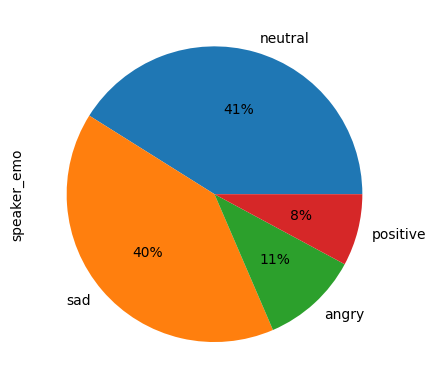

In [ ]:
crowd_train['speaker_emo'].value_counts(ascending=False).plot(kind='pie', autopct='%1.0f%%')

In [ ]:
neutral_count = len(crowd_train[crowd_train['speaker_emo'] == 'neutral'])
neutral_count

3000

In [ ]:
sad_count = len(crowd_train[crowd_train['speaker_emo'] == 'sad'])
sad_count

3000

In [ ]:
angry_count = len(crowd_train[crowd_train['speaker_emo'] == 'angry'])
angry_count

3000

In [ ]:
positive_count = len(crowd_train[crowd_train['speaker_emo'] == 'positive'])
positive_count

3000

In [ ]:
len_new = 3000

new_crowd_train = pd.DataFrame()

for emo in crowd_train['speaker_emo'].unique():
    emo_subset = crowd_train[crowd_train['speaker_emo'] == emo][:len_new]
    new_crowd_train = pd.concat([new_crowd_train, emo_subset])

crowd_train = new_crowd_train

<Axes: ylabel='speaker_emo'>

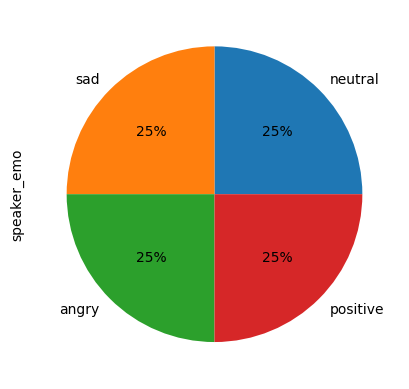

In [ ]:
crowd_train['speaker_emo'].value_counts(ascending=False).plot(kind='pie', autopct='%1.0f%%')

Приступаем к дальнейшему анализу полученного урезанного датасета

<ipython-input-16-267ff43c9958>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(crowd_train['duration'], label='crowd_train', hist=False)
<ipython-input-16-267ff43c9958>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(crowd_test['duration'], label='crowd_test', hist=False)


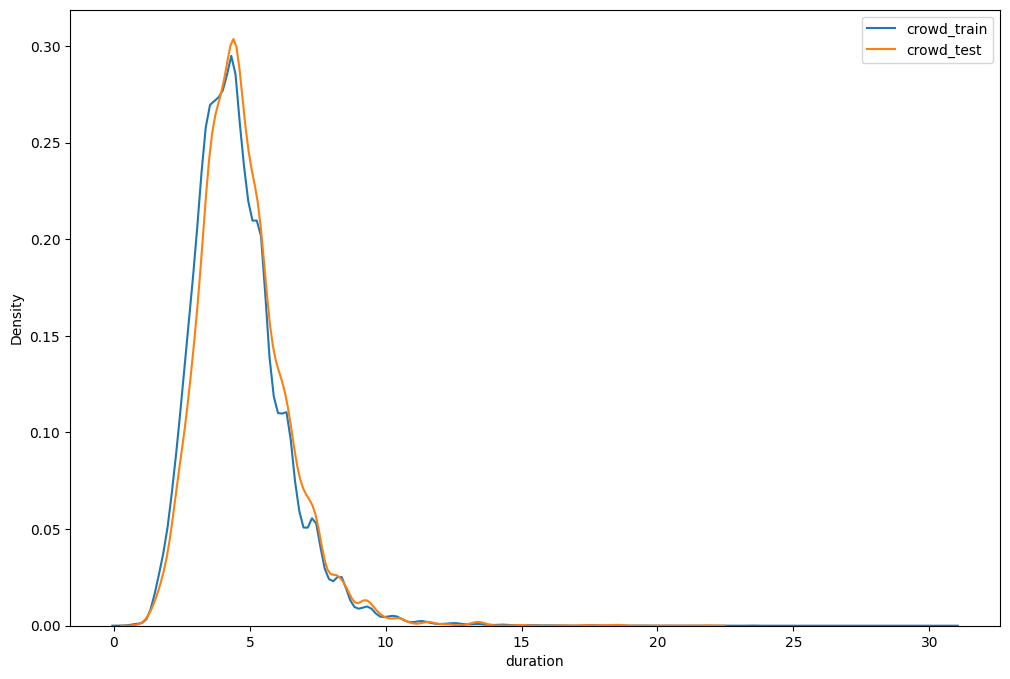

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(crowd_train['duration'], label='crowd_train', hist=False)
sns.distplot(crowd_test['duration'], label='crowd_test', hist=False)
plt.legend()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar()

def create_mfcc(data, sr, e):
    plt.figure(figsize=(11, 3))
    mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length=512, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.show()
    plt.plot(np.mean(mfcc.T, axis=0))
    plt.show()
    return mfcc

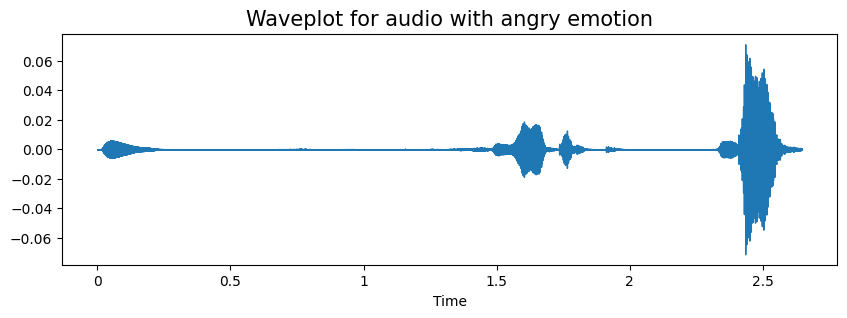

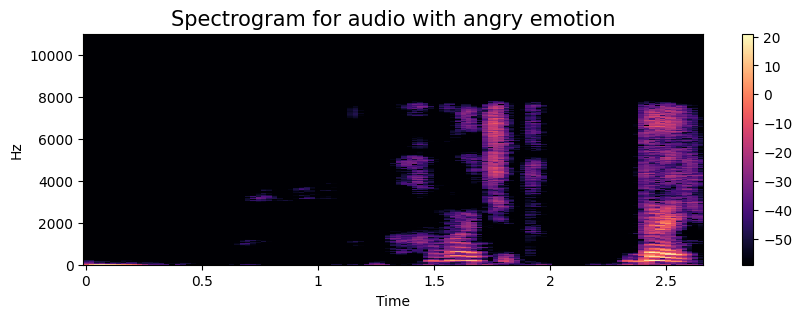

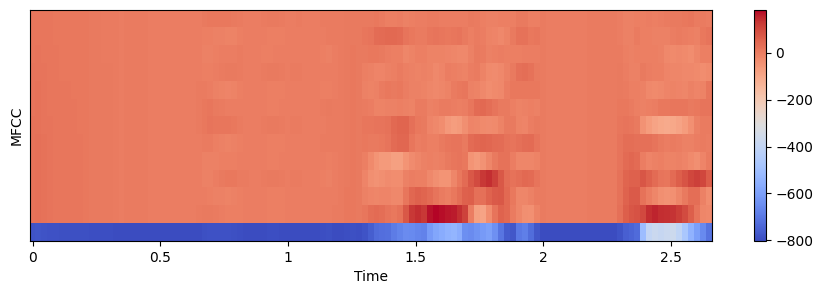

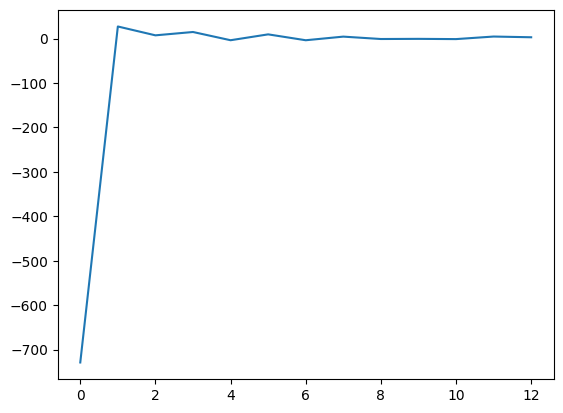

In [ ]:
emo = 'angry'
path = crowd_train[crowd_train['speaker_emo'] == emo]['audio_path'].iloc[3]
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
sampling_rate = sr
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sampling_rate, emo)
create_spectrogram(xt, sampling_rate, emo)
mfcc_p = create_mfcc(xt, sampling_rate, emo)
#Audio(path)

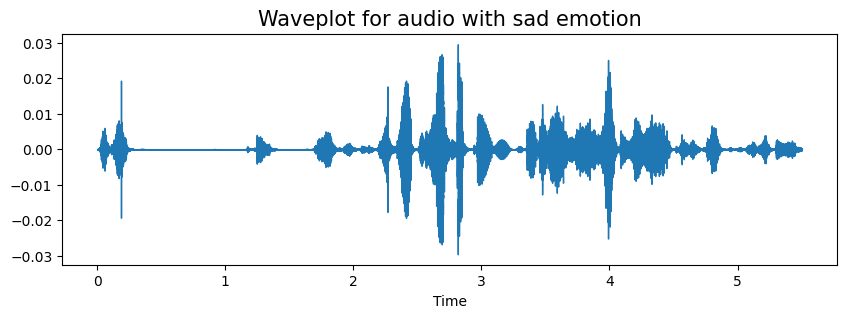

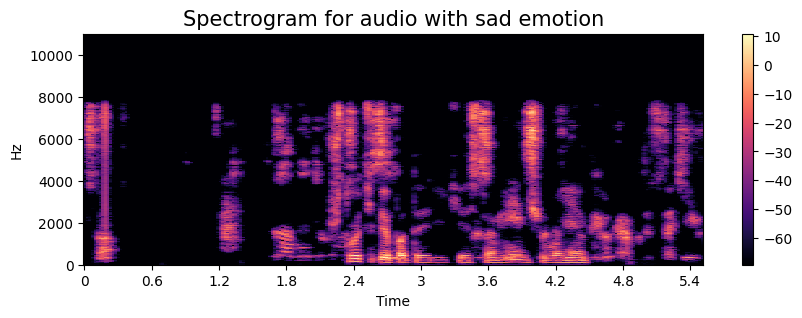

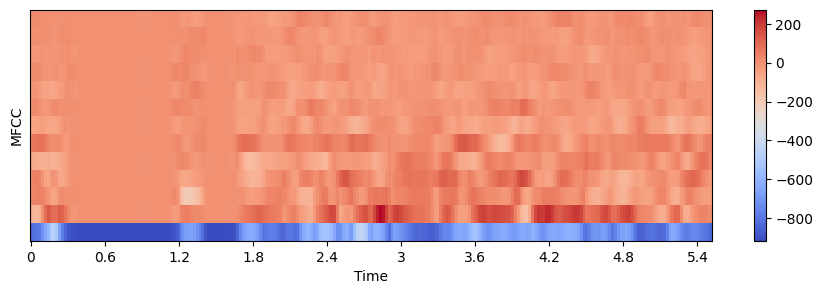

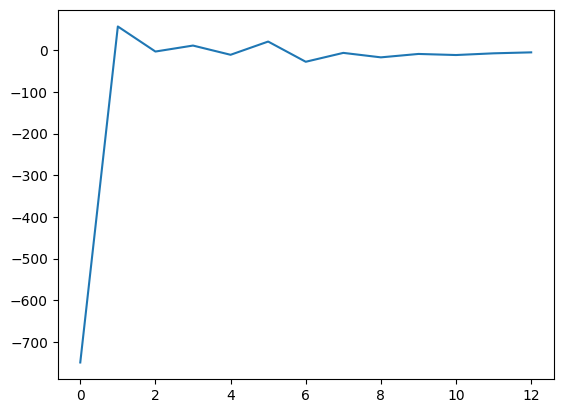

In [ ]:
emo = 'sad'
path = crowd_train[crowd_train['speaker_emo'] == emo]['audio_path'].iloc[3]
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
sampling_rate = sr
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sampling_rate, emo)
create_spectrogram(xt, sampling_rate, emo)
mfcc_p = create_mfcc(xt, sampling_rate, emo)
#Audio(path)

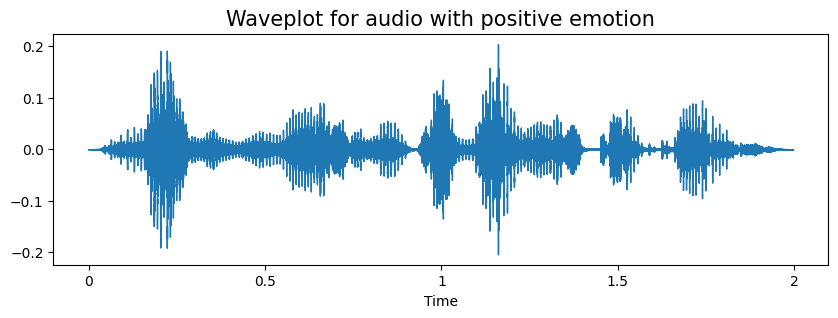

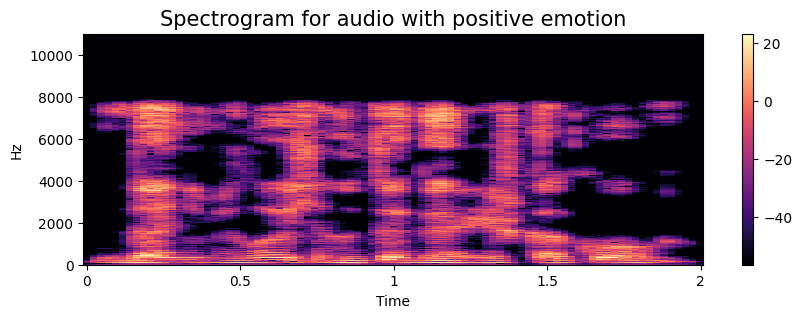

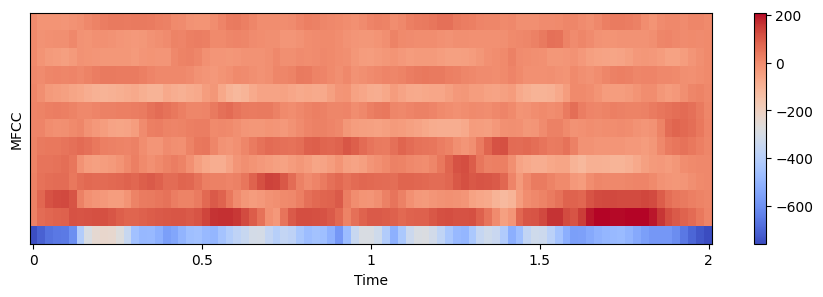

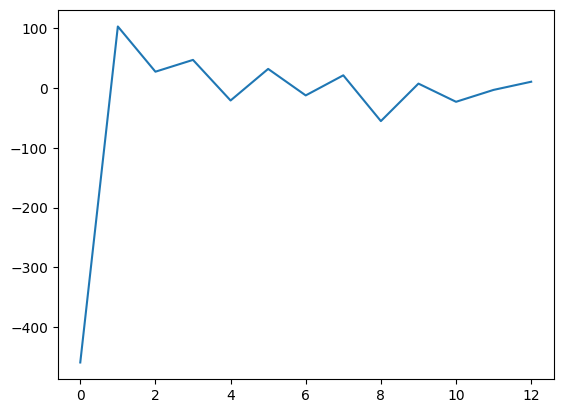

In [ ]:
emo = 'positive'
path = crowd_train[crowd_train['speaker_emo'] == emo]['audio_path'].iloc[3]
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
sampling_rate = sr
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sampling_rate, emo)
create_spectrogram(xt, sampling_rate, emo)
mfcc_p = create_mfcc(xt, sampling_rate, emo)
#Audio(path)

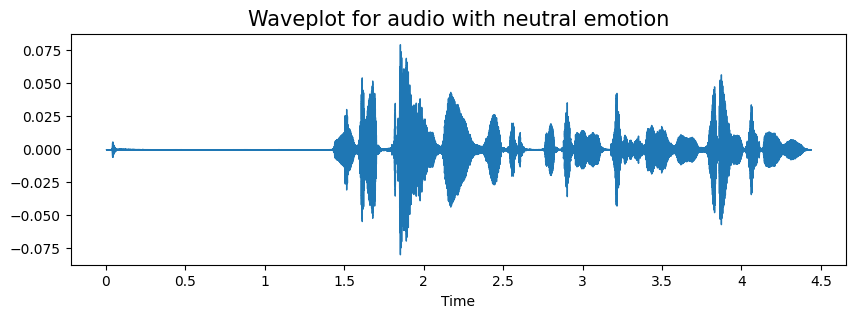

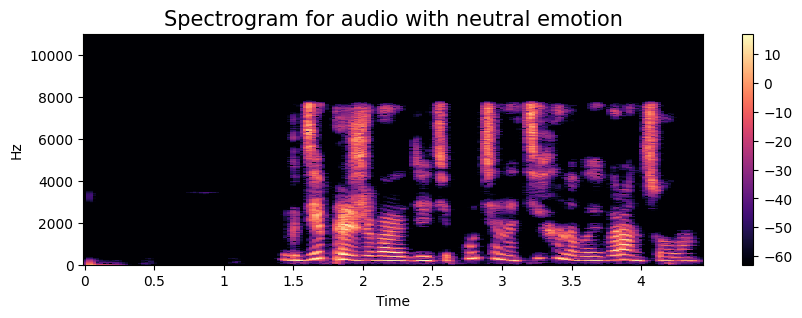

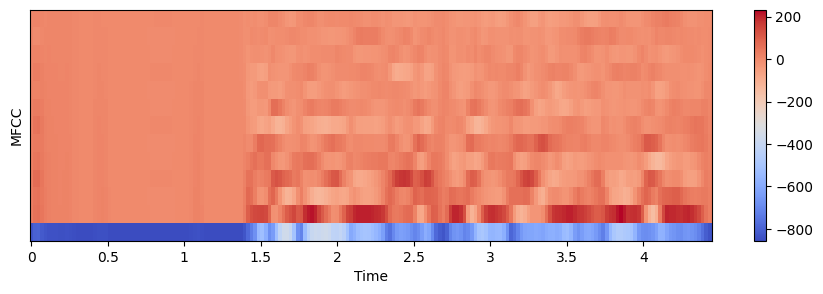

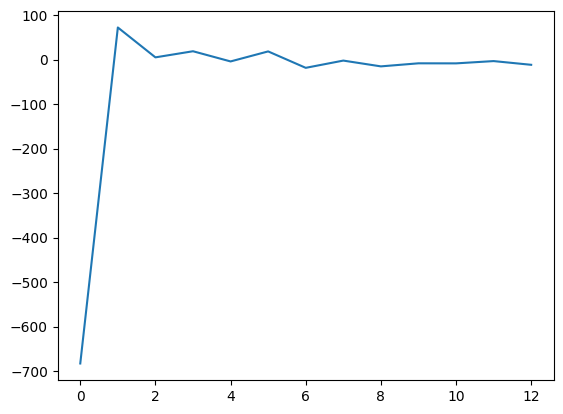

In [ ]:
emo = 'neutral'
path = crowd_train[crowd_train['speaker_emo'] == emo]['audio_path'].iloc[3]
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
sampling_rate = sr
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sampling_rate, emo)
create_spectrogram(xt, sampling_rate, emo)
mfcc_p = create_mfcc(xt, sampling_rate, emo)
#Audio(path)

Text(0.5, 1.0, 'Mean MFCC на Crowd, после предобработки')

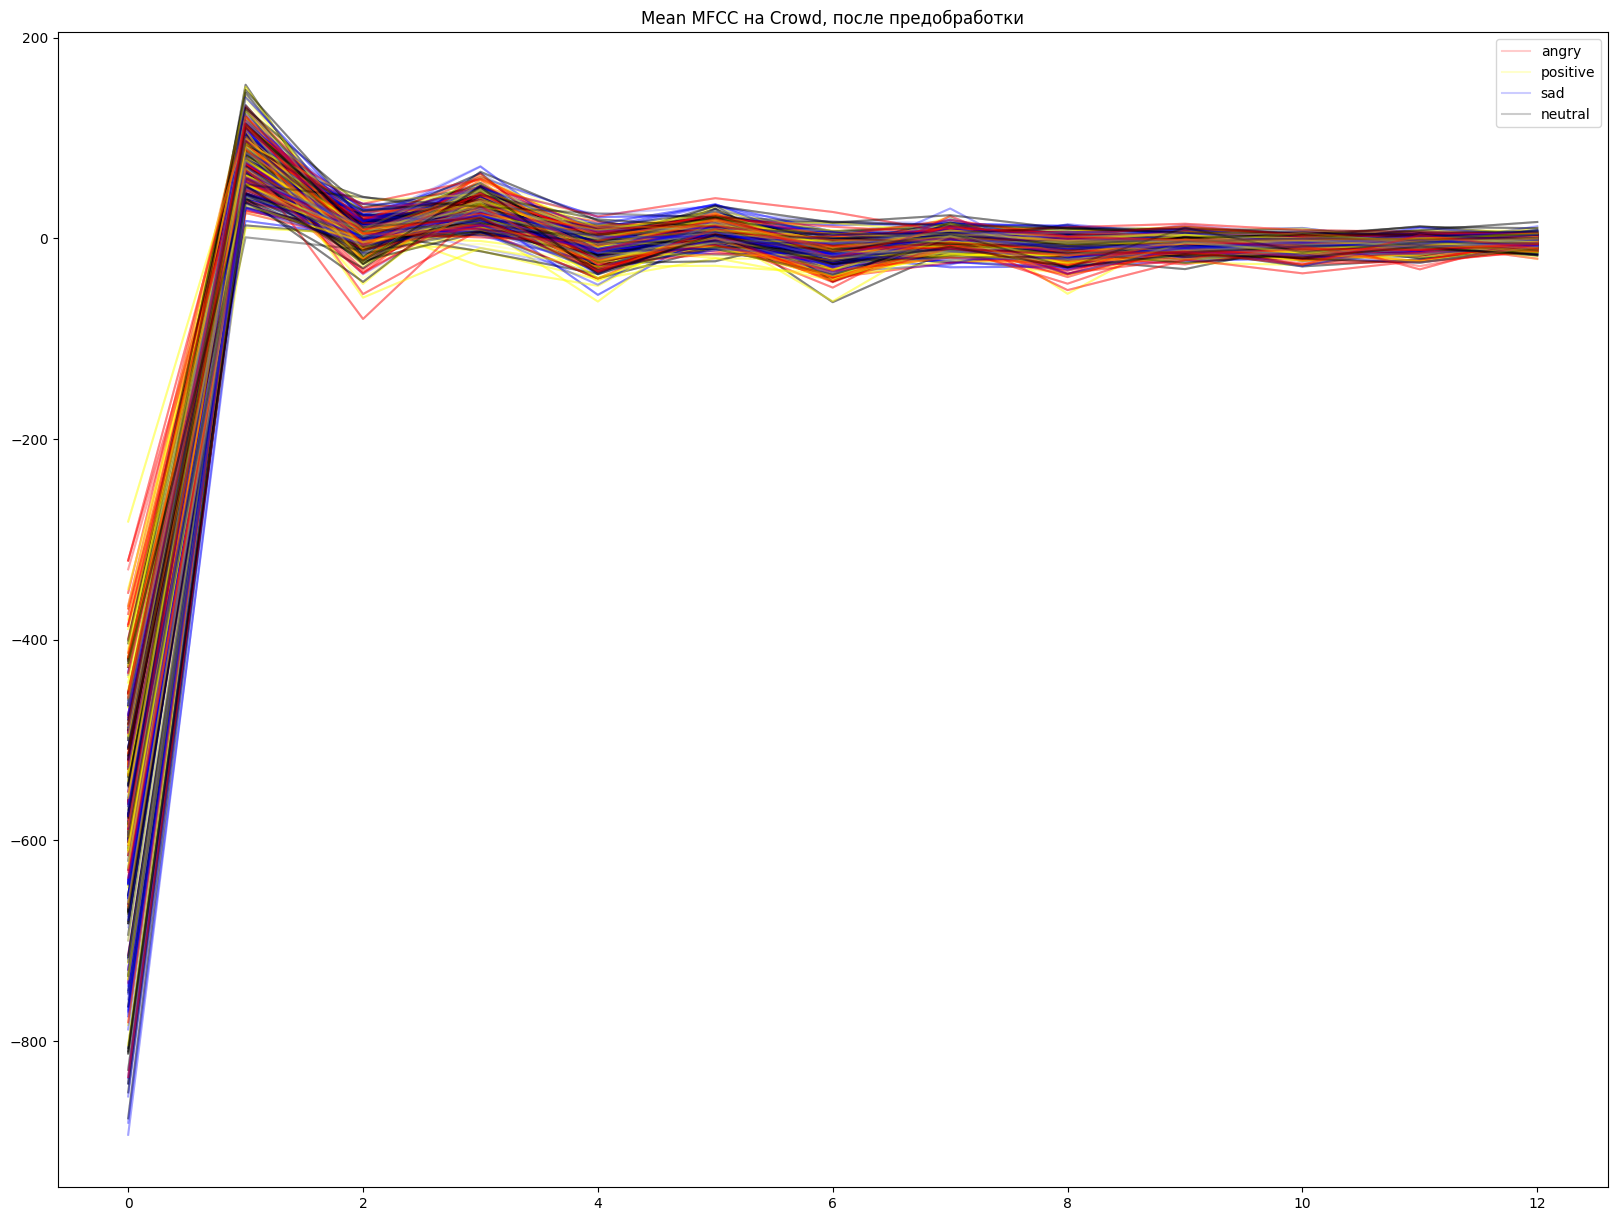

In [ ]:
plt.figure(figsize=(20, 15))
colors = ['', 'black', 'yellow', 'blue', '', 'red']
for i in range(200):
    for emo in ['angry', 'positive', 'sad', 'neutral']:
        path = crowd_train[crowd_train['speaker_emo'] == emo]['audio_path'].iloc[i]
        data, sr = librosa.load(path)
        data = nr.reduce_noise(data, sr=sr)
        data, index = librosa.effects.trim(data, top_db=33)
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13), axis=1)
        if i==0:
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2, label=emo)
        else:
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2)
plt.legend()
plt.title('Mean MFCC на Crowd, после предобработки')

Т.к. теперь датасет урезан, полностью сбалансирован и проанализирован, мы можем приступать к построению моделей обучения

2. Решить задачу классификации классическими методами машинного обучения.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
def create_mfcc(data, sr):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length=512, n_mfcc=13)
    return np.mean(mfcc.T, axis=0)
crowd_train.fillna(value=0, inplace=True)

In [ ]:
X = []
y = []

for index, row in crowd_train.iterrows():
    path = f"{row['audio_path']}"
    data, sr = librosa.load(path)
    data = nr.reduce_noise(data, sr=sr)
    data, _ = librosa.effects.trim(data, top_db=33)
    mfcc = create_mfcc(data, sr)
    X.append(mfcc)
    y.append(row['speaker_emo'])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Shape of X: (12000, 13)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

itog = {}

Метод опорных векторов

In [ ]:
from sklearn.metrics import classification_report

svm_model = SVC(kernel='rbf', C=100, gamma=0.001, class_weight='balanced')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.86875
Classification Report:
               precision    recall  f1-score   support

       angry       0.85      0.86      0.85       612
     neutral       0.88      0.87      0.87       624
    positive       0.89      0.86      0.87       596
         sad       0.86      0.89      0.88       568

    accuracy                           0.87      2400
   macro avg       0.87      0.87      0.87      2400
weighted avg       0.87      0.87      0.87      2400



Метод Случайного Леса

In [ ]:
%%time
rf= RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))
itog['RandomForestClassifier'] = round(accuracy_score(y_test, y_pred), 2)

0.8758333333333334
CPU times: user 3.39 s, sys: 9.16 ms, total: 3.4 s
Wall time: 3.4 s


In [ ]:
y_test = pd.Series(y_test, name='Actual').reset_index(drop=True)
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_test, y_pred)

print(df_confusion)

Predicted  angry  neutral  positive  sad
Actual                                  
angry        522       33        35   22
neutral       20      549        28   27
positive      39       25       519   13
sad           21       18        17  512


In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       angry       0.87      0.85      0.86       612
     neutral       0.88      0.88      0.88       624
    positive       0.87      0.87      0.87       596
         sad       0.89      0.90      0.90       568

    accuracy                           0.88      2400
   macro avg       0.88      0.88      0.88      2400
weighted avg       0.88      0.88      0.88      2400



Обучение с помощью RNN

In [ ]:
import librosa
import noisereduce as nr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, Reshape

In [ ]:
X = []
y = []

for index, row in crowd_train.iterrows():
    path = f"{row['audio_path']}"
    data, sr = librosa.load(path)
    data = nr.reduce_noise(data, sr=sr)
    data, _ = librosa.effects.trim(data, top_db=33)
    mfcc = create_mfcc(data, sr)
    X.append(mfcc)
    y.append(row['speaker_emo'])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)


/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Shape of X: (8000, 13)


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)

(9600, 13, 1)


In [ ]:
model = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 11, 128)           512       
                                                                 
 lstm_4 (LSTM)               (None, 11, 128)           131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 264196 (1.01 MB)
Trainable params: 264196 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy}')

Epoch 1/15
150/150 [==============================] - 20s 86ms/step - loss: 1.3675 - accuracy: 0.3156 - val_loss: 1.3573 - val_accuracy: 0.3262
Epoch 2/15
150/150 [==============================] - 9s 63ms/step - loss: 1.3582 - accuracy: 0.3255 - val_loss: 1.3596 - val_accuracy: 0.3104
Epoch 3/15
150/150 [==============================] - 11s 75ms/step - loss: 1.3480 - accuracy: 0.3340 - val_loss: 1.3510 - val_accuracy: 0.3229
Epoch 4/15
150/150 [==============================] - 13s 87ms/step - loss: 1.3362 - accuracy: 0.3467 - val_loss: 1.3391 - val_accuracy: 0.3425
Epoch 5/15
150/150 [==============================] - 15s 99ms/step - loss: 1.3221 - accuracy: 0.3613 - val_loss: 1.3325 - val_accuracy: 0.3587
Epoch 6/15
150/150 [==============================] - 12s 83ms/step - loss: 1.3069 - accuracy: 0.3781 - val_loss: 1.3364 - val_accuracy: 0.3600
Epoch 7/15
150/150 [==============================] - 9s 63ms/step - loss: 1.2847 - accuracy: 0.3997 - val_loss: 1.3255 - val_accuracy: 0

In [ ]:
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_data=(X_test, y_test))

accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy}')

Epoch 1/4
150/150 [==============================] - 12s 80ms/step - loss: 0.3358 - accuracy: 0.8979 - val_loss: 0.8049 - val_accuracy: 0.7617
Epoch 2/4
150/150 [==============================] - 13s 86ms/step - loss: 0.2316 - accuracy: 0.9370 - val_loss: 0.7680 - val_accuracy: 0.7937
Epoch 3/4
150/150 [==============================] - 20s 137ms/step - loss: 0.1553 - accuracy: 0.9620 - val_loss: 0.7292 - val_accuracy: 0.8354
Epoch 4/4
75/75 [==============================] - 1s 15ms/step - loss: 0.7088 - accuracy: 0.8554
Test Accuracy: 0.8554166555404663


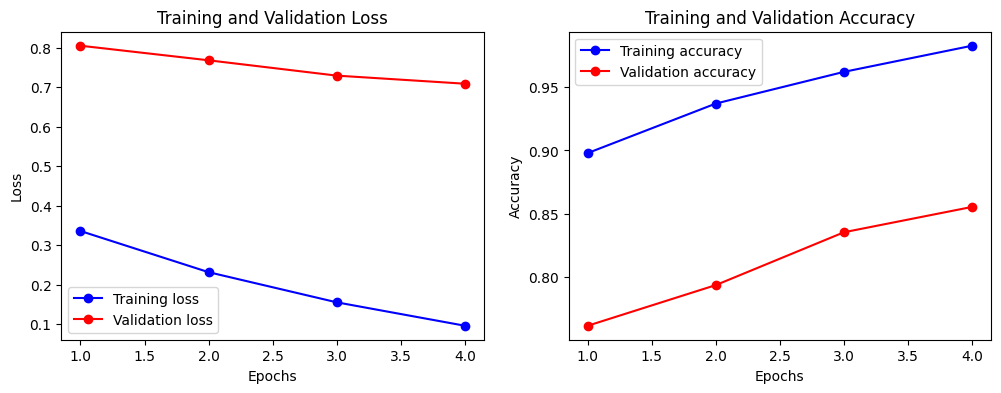

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

75/75 [==============================] - 3s 28ms/step


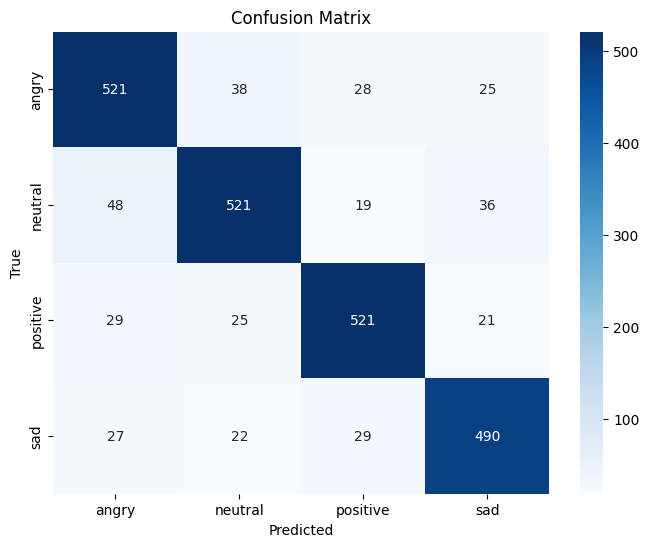

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Задание 4 + 5. Разработать систему онлайн записи аудиофайлов и ее транскрибации с использованием Whisper (https://github.com/openai/whisper/). 5.	Примените ruBERT для анализа тональности текста

In [ ]:
pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801356 sha256=ec856c7d6e7cc2249be7036f8944c276c4efcda71bca64664c8b1f7409eaa8c1
  Stored in directory: /root/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [ ]:
pip install transformers

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import whisper
import torch

In [ ]:
def transcribe_audio(file_path, model):
    result = model.transcribe(file_path)
    return result["text"]

def predict_sentiment(text, model, tokenizer, sentiment_labels):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).item()
    return sentiment_labels[predictions]

In [ ]:
whisper_model = whisper.load_model("base")

model_path = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_path)
ruBERT_model = BertForSequenceClassification.from_pretrained(model_path)

sentiment_labels = ["Очень негативная", "Негативная", "Нейтральная", "Позитивная", "Очень позитивная"]

audio_files = ["./1.wav", "./2.wav"]

for file_path in audio_files:
    transcribed_text = transcribe_audio(file_path, whisper_model)
    sentiment_prediction = predict_sentiment(transcribed_text, ruBERT_model, tokenizer, sentiment_labels)

    print(f"Audio File: {file_path}")
    print(f"Transcribed Text: {transcribed_text}")
    print(f"Sentiment Prediction: {sentiment_prediction}\n")

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 129MiB/s]


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Audio File: ./1.wav
Transcribed Text:  Ну мужик, с днем рождения, счастья любви везения! Будь старого мужик в своей дождении! И идите на примик счастью и везению! Идите на примик счастью и везению! Пожелать позволь хорошим!
Sentiment Prediction: Очень позитивная



/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Audio File: ./2.wav
Transcribed Text:  Реми, Реми, проснись. Доктор потрясо жену заплечал, но она была где-то далеко. Бутто в коме. Тело безвольное и мягкое, как от репичной куклы. Помогите мне. Снова сказал чужой голос, да насящаяся и сделаю его жены. Меня зовут Терасита Баса. Меня убили. Вы должны поймать моего убийцу. Доктор отскочил на другой конец комнаты. Реми снова позвал он. А. И вовжена приоткрыла глаза. Что случилось? Казала она уже своим голосом. Реми, а кто такая Терасита Баса? Терасита? Кио не знаю. Я не знакомы ни с кем, кого бы так звали. Я, возможно, не правиль сказал ударения в их именах. У меня такая фишка.
Sentiment Prediction: Очень негативная

